In [1]:
import numpy as np
import torch 
from torch import nn
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.autograd import grad
import os
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rc('savefig', dpi=300)

import numpy as np
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
T = 1 # time [0, T]
N = 1000 # split [0, T] into N parts
h = 1e-2 
m = 1 
sig2 = np.sqrt(0.1)
mu = 0
d = 1 # points from R^d
x0_phase = -5

In [4]:
time_splits = torch.Tensor(np.linspace(0, T, N+1)) #.repeat(d).reshape(d, N+1)

In [5]:
class NN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim) 
        self.relu1 = nn.Tanh()
        self.relu2 = nn.Tanh()
        self.fc2 = nn.Linear(hid_dim, hid_dim)  
        self.fc4 = nn.Linear(hid_dim, output_dim) 

    def forward(self, x, t):
        out = torch.hstack((x, t))
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc4(out)
        return out

In [7]:
def V_x_i(x): # should be grad of V
    return (x - 0.1*torch.ones(x.shape).to(device))

def v_0(x):
    return h / m * torch.tensor(x0_phase).repeat(x.shape[0]).reshape(-1, 1)

def u_0(x):
    return -h * x / (2 * m * (sig2**2))

In [9]:
dim_inp = d + 1
dim_out = d
dim_hid = 300 #400
net_u = NN(dim_inp, dim_hid, dim_out).to(device);
net_v = NN(dim_inp, dim_hid, dim_out).to(device);

criterion = nn.MSELoss()
learning_rate = 1e-3 #1e-4#0.001 #1e-6 #0.01

optimizer = torch.optim.Adam([*net_u.parameters(), *net_v.parameters()], lr=learning_rate, 
                           weight_decay=0) 

alpha = 1 # Score
beta = 1 # Newton
gamma = 1 # initial

In [ ]:
n_iter = 5000 #2000 
iter_threshhold = 1000 
batch_size = 100 #512 # 1000
loss_ref = np.inf
lines = [None, None, None]
losses = []
losses_newton = []
losses_sm = []
losses_init = []
N_fast = N

with tqdm(range(n_iter), unit="iter") as tepoch:
    for tau in tepoch:
        if tau == 0: 
#             print('Iter 0, just generate batches')
            l_sm = 0
            l_nl = 0
            X_0 = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), batch_size)).to(device)
            X_0.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0)).to(device)
            v0_val = torch.Tensor(v_0(X_0)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), batch_size) for i in range(N+1)]
            for i in range(1, N_fast+1): # iterate over time steps
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0.clone().to(device) # X_{i-1}
                else:
                    X_prev = X_i.clone().to(device) # X_{i-1}

                t_i = time_splits[i].clone()
                
                t_prev_batch = time_transform(t_prev).expand(batch_size, 1).to(device).clone()
                X_i = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)
 
                if i > 1: 
                    Xs = torch.hstack((Xs, X_i))
                else:
                    Xs = X_i.clone()
   
            X_0_iter0 = X_0.clone() # collect X_0 from the initial iter
            Xs = torch.concat((X_0_iter0, Xs), axis=1)
        elif tau > iter_threshhold: 
            BATCH_size = int(0.2* batch_size) #int(0.5* batch_size) 10
            
            X_0_iter = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), BATCH_size)).to(device)
            X_0_iter.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0_iter)).to(device)
            v0_val = torch.Tensor(v_0(X_0_iter)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), BATCH_size) for i in range(N+1)]
            # get one trajectory
            for i in range(1, N_fast+1): 
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0_iter.clone().to(device) 
                else:
                    X_prev = X_i_iter.clone().to(device) 

                t_i = time_splits[i].clone()
                
                t_prev_batch = time_transform(t_prev).expand(BATCH_size, 1).to(device)
                X_i_iter = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)
 
                if i > 1: 
                    Xs_iter = torch.hstack((Xs_iter, X_i_iter))
                else:
                    Xs_iter = X_i_iter.clone()
            Xs_iter = torch.concat((X_0_iter, Xs_iter), axis=1)
            
            # replace the old batch with the new one
            Xs_all = Xs_all.reshape((batch_size, (N+1)*d))
            X_0_all = X_0_all.reshape((batch_size, d))
            Xs_all = torch.roll(Xs_all, -BATCH_size, 0)
            X_0_all = torch.roll(X_0_all, -BATCH_size, 0)
            Xs_all = torch.vstack((Xs_all[BATCH_size:].detach(), Xs_iter.detach()) )
            Xs_all.requires_grad = True

            X_0_all = torch.vstack((X_0_all[BATCH_size:].detach(), X_0_iter.detach()) )
            X_0_all.requires_grad = True 
            
            Xs_all = Xs_all.reshape(batch_size*(N+1), d)
            X_0_all = X_0_all.reshape(batch_size, d)
            
            time_splits_batches = time_splits.repeat(batch_size).reshape(batch_size, N+1).reshape(batch_size*(N+1), 1).to(device)
            time_splits_batches.requires_grad = True
            
            out_u = net_u(Xs_all, time_splits_batches)
            out_v = net_v(Xs_all, time_splits_batches)
            
            du_dt = grad(out_u, time_splits_batches, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_dt = grad(out_v, time_splits_batches, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]

            dv_dx = grad(out_v, Xs_all, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]
            du_dx = grad(out_u, Xs_all, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_ddx = grad(dv_dx, Xs_all, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
            du_ddx = grad(du_dx, Xs_all, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

            out_uv = net_v(Xs_all, time_splits_batches) * net_u(Xs_all, time_splits_batches)
            dvu_dx = grad(out_uv, Xs_all, grad_outputs=torch.ones_like(out_uv), create_graph=True)[0]
            
            L_sm = criterion(du_dt, -(h/(2*m)) * dv_ddx - dvu_dx) 

            L_nl = criterion(dv_dt, -out_v * dv_dx + out_u * du_dx + (h / 2 / m) * du_ddx \
                               -V_x_i(Xs_all).to(device)/m) 
            
            u0_val = torch.Tensor(u_0(X_0_all)).to(device)
            v0_val = torch.Tensor(v_0(X_0_all)).to(device)
            L_ic = criterion(net_u(X_0_all, 
                                   time_splits[0].expand(batch_size, 1).to(device)), u0_val) \
                     + criterion(net_v(X_0_all, 
                                       time_splits[0].expand(batch_size, 1).to(device)), v0_val)
            
            loss = (alpha * L_sm + beta * L_nl + gamma * L_ic) / 3.0
            losses.append(loss.item())
            losses_newton.append(L_nl.item())
            losses_sm.append(L_sm.item())
            losses_init.append(L_ic.item())
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(losses[-10:]), loss_std=np.std(losses[-10:]), 
                               loss_sm=np.mean(losses_sm[-10:]), loss_nl=np.mean(losses_newton[-10:]), 
                               loss_ic=np.mean(losses_init[-10:]))

            loss.backward()
            optimizer.step()
            
        elif tau <= iter_threshhold:
            BATCH_size = int(0.6* batch_size)

            X_0_iter = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), BATCH_size)).to(device)
            X_0_iter.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0_iter)).to(device)
            v0_val = torch.Tensor(v_0(X_0_iter)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), BATCH_size) for i in range(N+1)]
            # get one trajectory
            for i in range(1, N_fast+1): 
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0_iter.clone().to(device) 
                else:
                    X_prev = X_i_iter.clone().to(device) 

                t_i = time_splits[i].clone()

                t_prev_batch = time_transform(t_prev).expand(BATCH_size, 1).to(device)
                X_i_iter = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)

                if i > 1: 
                    Xs_iter = torch.hstack((Xs_iter, X_i_iter))
                else:
                    Xs_iter = X_i_iter.clone()
            Xs_iter = torch.concat((X_0_iter, Xs_iter), axis=1)
            
            # replace the old batch with the new one
            if tau == 1:
                Xs_all = torch.vstack((Xs[BATCH_size:].detach(), Xs_iter.detach()) )
                Xs_all.requires_grad = True

                X_0_all = torch.vstack((X_0_iter0[BATCH_size:].detach(), X_0_iter.detach()) )
                X_0_all.requires_grad = True
            else:
                Xs_all = Xs_all.reshape((batch_size, (N+1)*d))
                X_0_all = X_0_all.reshape((batch_size, d))
                Xs_all = torch.roll(Xs_all, -BATCH_size, 0)
                X_0_all = torch.roll(X_0_all, -BATCH_size, 0)
                Xs_all = torch.vstack((Xs_all[BATCH_size:].detach(), Xs_iter.detach()) )
                Xs_all.requires_grad = True

                X_0_all = torch.vstack((X_0_all[BATCH_size:].detach(), X_0_iter.detach()) )
                X_0_all.requires_grad = True

#             Xs_all = Xs_all.reshape(batch_size*N, d)
#             print("!", X_0_all.shape,  Xs_all.shape)
#             Xs_all = torch.concatenate((X_0_all, Xs_all), axis=1)
#             print("!!", X_0_all.shape,  Xs_all.shape)
            Xs_all = Xs_all.reshape(batch_size*(N+1), d)
            X_0_all = X_0_all.reshape(batch_size, d)

            time_splits_batches = time_splits.repeat(batch_size).reshape(batch_size, N+1).reshape(batch_size*(N+1), 1).to(device)
            time_splits_batches.requires_grad = True

            out_u = net_u(Xs_all, time_splits_batches)
            out_v = net_v(Xs_all, time_splits_batches)
            
            du_dt = grad(out_u, time_splits_batches, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_dt = grad(out_v, time_splits_batches, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]

            dv_dx = grad(out_v, Xs_all, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]
            du_dx = grad(out_u, Xs_all, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_ddx = grad(dv_dx, Xs_all, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
            du_ddx = grad(du_dx, Xs_all, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

            out_uv = net_v(Xs_all, time_splits_batches) * net_u(Xs_all, time_splits_batches)
            dvu_dx = grad(out_uv, Xs_all, grad_outputs=torch.ones_like(out_uv), create_graph=True)[0]
            
            
            L_sm = criterion(du_dt, -(h/(2*m)) * dv_ddx - dvu_dx) 

            L_nl = criterion(dv_dt, -out_v * dv_dx + out_u * du_dx + (h / 2 / m) * du_ddx \
                               -V_x_i(Xs_all).to(device)/m) 

            u0_val = torch.Tensor(u_0(X_0_all)).to(device)
            v0_val = torch.Tensor(v_0(X_0_all)).to(device)
            L_ic = criterion(net_u(X_0_all, 
                                   time_splits[0].expand(batch_size, 1).to(device)), u0_val) \
                     + criterion(net_v(X_0_all, 
                                       time_splits[0].expand(batch_size, 1).to(device)), v0_val)

            loss = (alpha * L_sm + beta * L_nl + gamma * L_ic) / 3.0
            losses.append(loss.item())
            losses_newton.append(L_nl.item())
            losses_sm.append(L_sm.item())
            losses_init.append(L_ic.item())
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(losses[-10:]), loss_std=np.std(losses[-10:]), 
                               loss_sm=np.mean(losses_sm[-10:]), loss_nl=np.mean(losses_newton[-10:]), 
                               loss_ic=np.mean(losses_init[-10:]))
            
            loss.backward(retain_graph=True)
            optimizer.step()
        else:
            print('NO CHOICE')
            

 25%|███▉            | 1232/5000 [15:32<46:41,  1.34iter/s, loss_ic=5.92e-5, loss_iter=9.32e-5, loss_mean=0.000119, loss_nl=0.000236, loss_sm=6.11e-5, loss_std=3.05e-5]

In [65]:
# torch.save(net_u.to('cpu'), 'net_u_1d_s0_5.pth')
# torch.save(net_v.to('cpu'), 'net_v_1d_s0_5.pth')

In [11]:
net_u = torch.load('net_u_1d_s0_5_1.pth')
net_v = torch.load('net_v_1d_s0_5_1.pth')
net_u.to(device); net_v.to(device);

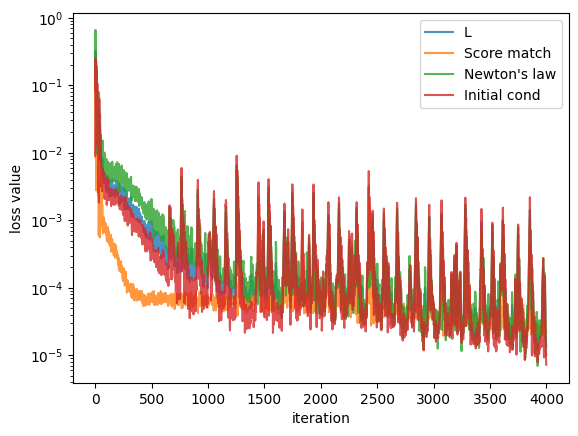

In [9]:
plt.plot(losses, alpha=0.8, label='L')
plt.plot(losses_sm, alpha=0.8,  label='Score match')
plt.plot(losses_newton, alpha=0.8,  label='Newton\'s law')
plt.plot(losses_init, alpha=0.8,  label='Initial cond')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.yscale('log')
plt.legend();

In [12]:
def plot_stats(x, m, v, t, sol_m, sol_v):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    x = time_splits.numpy()

    axs[0].plot(x, m.mean(axis=0), color='green', label='preds', linewidth=0.8)
    axs[0].plot(x, m.mean(axis=0) - m.std(axis=0), linestyle='--', color='seagreen', linewidth=0.8)
    axs[0].plot(x, m.mean(axis=0) + m.std(axis=0), linestyle='--', color='seagreen', linewidth=0.8)
    axs[0].fill_between(x, m.mean(axis=0) - m.std(axis=0), 
                        m.mean(axis=0) + m.std(axis=0), color='seagreen', 
                        alpha=0.5, linewidth=0.8)
    axs[0].plot(t, sol_m, color='black', linestyle='--', label='truth', linewidth=0.8)
    axs[0].set_xlabel('time')
    axs[0].legend();
    axs[0].set_title('Harmonic oscillator 1D mean')

    axs[1].plot(x, v.mean(axis=0), color='dodgerblue', label='preds', linewidth=0.8)
    axs[1].plot(x, v.mean(axis=0) - v.std(axis=0), linestyle='--', color='dodgerblue', linewidth=0.8)
    axs[1].plot(x, v.mean(axis=0) + v.std(axis=0), linestyle='--', color='dodgerblue', linewidth=0.8)
    axs[1].fill_between(x, v.mean(axis=0) - v.std(axis=0), 
                        v.mean(axis=0) + v.std(axis=0), color='dodgerblue', 
                        alpha=0.5, linewidth=0.8)
    axs[1].plot(t, sol_v, color='black', linestyle='--', label='truth', linewidth=0.8)
    axs[1].set_title('Harmonic oscillator 1D variance') 
    axs[1].set_xlabel('time')
    axs[1].legend();

In [15]:
dx    = np.sqrt(1 / 200000) # np.sqrt(T / 1000)    100000                    # spatial separation
x     = np.arange(-2, 2, dx)       # spatial grid points
print(dx, x.shape)

kx    = 0                        # mass
sigma = sig2                      # width of initial gaussian wave-packet
x0    = 0.0                     # center of initial gaussian wave-packet

A = 1.0 / (sigma * np.sqrt(2*np.pi)) # normalization constant

# Initial Wavefunction
psi0 = np.sqrt(A) * np.exp(-(x-x0)**2 / (4.0 * (sigma**2))) * np.exp(1j * x0_phase * x )


# Potential V(x)
x_Vmin = 0.1         # center of V(x)

V = 0.5 * (x - x_Vmin)**2

# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2
# RHS of Schrodinger Equation
hbar = h
# hbar = 1.0545718176461565e-34
def psi_t(t, psi):
    return -1j * (-0.5 * hbar  / m * D2.dot(psi) + V / hbar * psi)

dt = T / 1000 # T / 10000 #T / 1000  # time interval for snapshots
t0 = 0.0    # initial time
tf = T    # final time
t_eval = np.linspace(t0, tf, N+1)#np.arange(t0, tf, dt) # np.linspace(t0, tf, len(x)**2) # np.arange(t0, tf, dt)  # recorded time shots
print(t_eval.shape)
# Solve the Initial Value Problem
sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")
bmeans = []
bstds = []
ts = []
for i, t in enumerate(sol.t):
    ts.append(t)
    bmeans.append(np.dot(x, dx * np.abs(sol.y[:,i])**2)) 
    
    bstds.append(np.dot((x - bmeans[-1]) ** 2, dx * np.abs(sol.y[:,i])**2))

0.00223606797749979 (1789,)
(1001,)


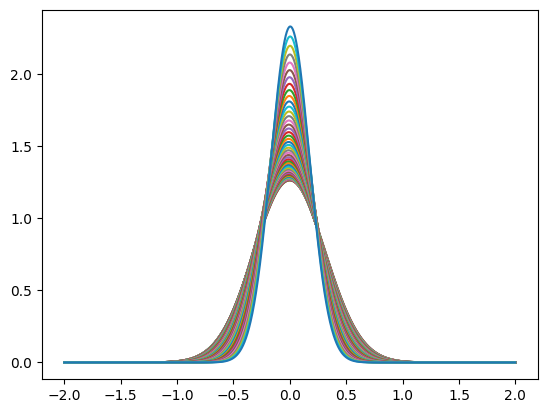

In [16]:
for i in range(0, len(sol.t), 20):
    plt.plot(x, np.abs(sol.y[:,i])**2) 

In [18]:
dens_num = np.abs(sol.y.T)**2

In [33]:
net_u.eval();
net_v.eval();

samples = 15000
N = 1000
num_trials = 10
X_test = np.zeros((num_trials, N+1, samples, d))

# can change nu value for sampling
# nu = 0 no u and noise during sampling (but still running net_u(x))
nu_s = 1

for trial in tqdm(range(num_trials)):
    with torch.no_grad():
        X_0 = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, (sig2**2)*np.eye(d), samples)).to(device)
        X_test[trial, 0, :] = X_0.cpu().numpy()
        X_prev = X_0.clone()
        eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), samples) for i in range(N)]    
        for i in range(1, N+1):
            a = torch.hstack((X_prev, time_splits[i-1].expand(samples, 1).to(device)))
            X_i = torch.Tensor(X_prev).to(device) + T / N * \
            (nu_s * net_u(X_prev, time_splits[i-1].expand(samples, 1).to(device)) \
             + net_v(X_prev, time_splits[i-1].expand(samples, 1).to(device))) \
                       + torch.Tensor(np.sqrt((h*T * nu_s)/(m*N)) * eps[i-1]).to(device)
            X_test[trial, i, :] = X_i.cpu().numpy()
            X_prev = X_i.clone()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


In [34]:
mean_trials = np.zeros((num_trials, N + 1, d))
var_trials = np.zeros((num_trials, N + 1, d))

for trial in range(num_trials):
    mean_trials[trial] = X_test[trial].mean(axis=1)
    var_trials[trial] = X_test[trial].var(axis=1)

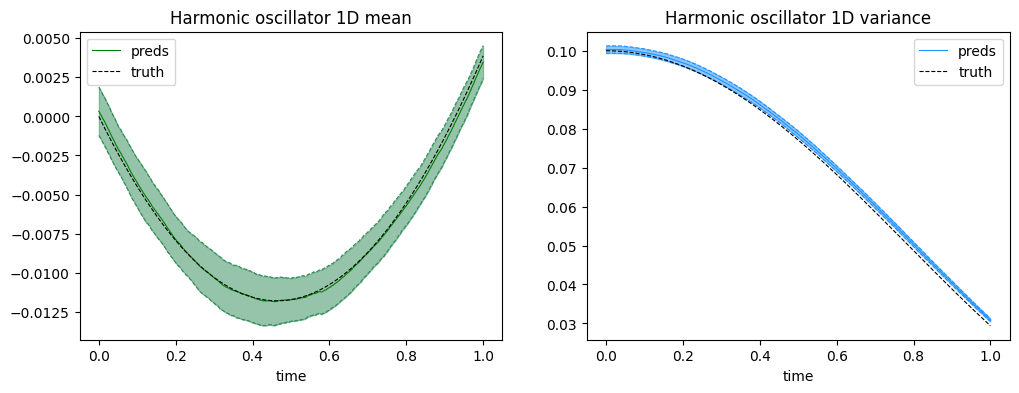

In [35]:
plot_stats(x, mean_trials[:, :, 0], var_trials[:, :, 0], ts, bmeans, bstds)

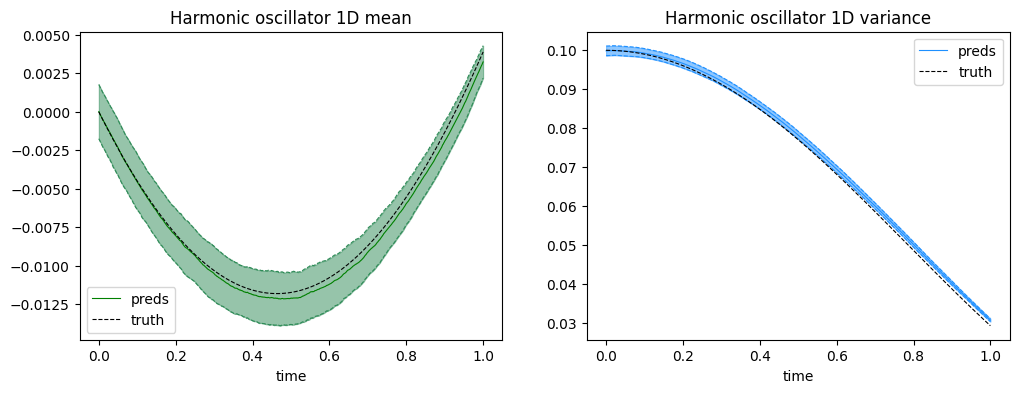

In [30]:
plot_stats(x, mean_trials[:, :, 0], var_trials[:, :, 0], ts, bmeans, bstds)

In [36]:
for i in range(d): 
    err_mean_xt = (np.linalg.norm(mean_trials[:, :, i] - np.array(bmeans), axis=1) / (np.linalg.norm(bmeans))).mean()
    err_mean_xt_std = (np.linalg.norm(mean_trials[:, :, i] - bmeans, axis=1) / (np.linalg.norm(bmeans))).std()

    err_std_xt = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).mean()
    err_std_std = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).std()
    print(i)
    print('1D Err(mean(X_t)_NN, mean(X_t)_num): ', err_mean_xt, err_mean_xt_std)
    print('1D Err(var(X_t)_NN, var(X_t)_num): ', err_std_xt, err_std_std)

0
1D Err(mean(X_t)_NN, mean(X_t)_num):  0.15581899206769206 0.07706204469546168
1D Err(var(X_t)_NN, var(X_t)_num):  0.018038652148200215 0.008665082336229634


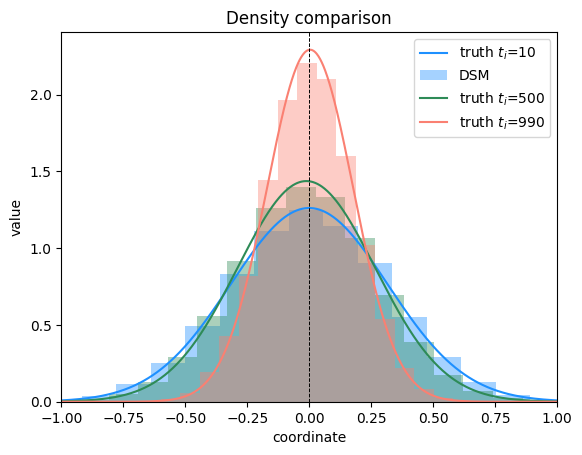

In [37]:
t_step=10
plt.plot(x, dens_num[t_step, :], color="dodgerblue", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step].reshape(-1), bins=20, color="dodgerblue", density=True, alpha=0.4, 
         label='DSM');
t_step=500
plt.plot(x, dens_num[t_step, :], color="seagreen", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step].reshape(-1), bins=20, color="seagreen", density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="seagreen", label='PINN')

t_step=990
plt.plot(x, dens_num[t_step, :], color="salmon", label='truth $t_i$={}'.format(t_step))
plt.hist(X_test[0:3, t_step].reshape(-1), bins=20, color="salmon", density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="purple")
plt.legend();

# t_step=990
# plt.plot(x, dens_num[t_step, :], color="salmon", label='truth $t_i$={}'.format(t_step))
# plt.hist(X_test[0:3, t_step].reshape(-1), bins=20, color="salmon",  density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="salmon")
plt.axvline(0, linestyle="--", color="black", linewidth=0.7)
plt.xlim(-1, 1)
plt.xlabel('coordinate')
plt.ylabel('value')
plt.legend();
plt.title('Density comparison');

In [38]:
# Doman bounds
lb = np.array([-2.0, 0.0])
ub = np.array([2.0, 1])

In [39]:
n_bins = len(x)
p = np.zeros((len(t_eval), n_bins))
for i in range(len(t_eval)):
    p[i, :] = np.histogram(X_test[0:9, i, :].reshape(-1), 
                           density=True, bins=n_bins, range=(-2, 2))[0]

/tmp/ipykernel_1141051/150130722.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[0, :])


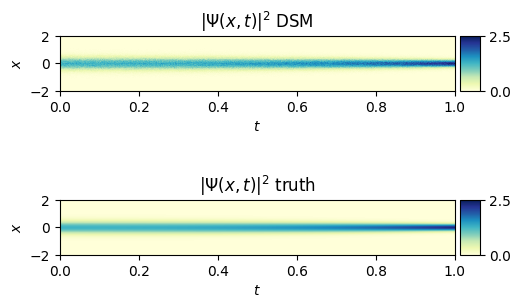

In [40]:
fig, ax = plt.subplots(1, 1) #newfig(1.0, 0.9)
fig.set_size_inches(6, 8)
# ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(2, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, hspace=2)
ax = plt.subplot(gs0[0, :])
ax1 = plt.subplot(gs0[1, :])

h_ = ax.imshow(p.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', vmin=0., vmax=2.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$|\Psi(x, t)|^2$ DSM', fontsize = 12);

h_ = ax1.imshow(dens_num.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', vmin=0., vmax=2.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_title('$|\Psi(x, t)|^2$ truth', fontsize = 12);